# Mean reverting model for pricing WTI Futures average option

In [1]:
# third party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

# internal 
from simulations.custom_model import asian_custom_mean_reverting_laplace
from helper_functions.evaluate_timeseries import evaluate_ts_data

import seaborn as sb
sb.set()

In [2]:
raw_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RCLC1d.xls", sheet_name=1, header=2)

In [3]:
raw_data.tail()

,Date,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)"
9282,2020-03-17,26.95
9283,2020-03-18,20.37
9284,2020-03-19,25.22
9285,2020-03-20,22.43
9286,2020-03-23,23.36


In [4]:
time_indexed_data = raw_data.set_index("Date")
time_indexed_data.tail()

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)"
Date,
2020-03-17,26.95
2020-03-18,20.37
2020-03-19,25.22
2020-03-20,22.43
2020-03-23,23.36


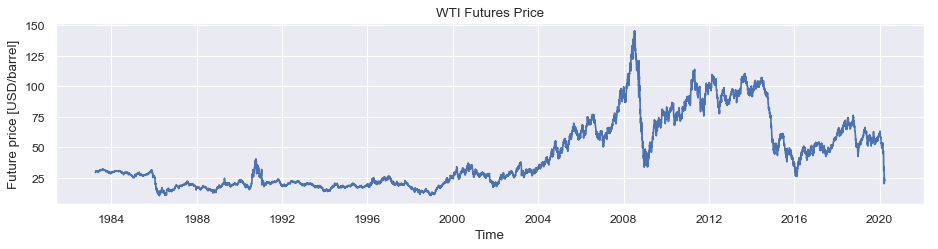

In [5]:
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(time_indexed_data)
plt.title("WTI Futures Price")
plt.xlabel("Time")
plt.ylabel("Future price [USD/barrel]")
plt.show()

Select just part of the entire time series

In [6]:
selected_ti = time_indexed_data.loc["2015-01-01":]
selected_ti.count()

Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)    1320
dtype: int64

In [7]:
rets = (selected_ti/selected_ti.shift(1))
rets = rets[rets.columns[0]].dropna()
lrets = np.log(rets)

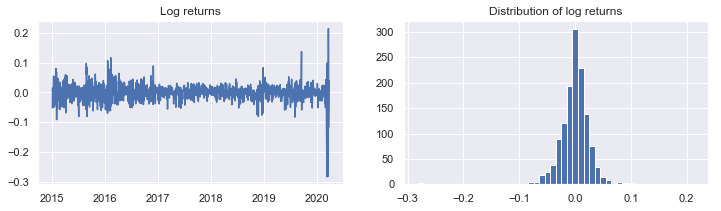

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,3))
ax1.set_title("Log returns")
ax1.plot(lrets)
ax2.set_title("Distribution of log returns")
ax2.hist(lrets,bins=50)
plt.show()


Jarque Bera test (tests for normality of data)
         Score  p value      skew  kurtosis
0  22827.16571      0.0 -1.223295  23.23285

Ljung-Box test ( tests autocorrelation)
      lb_stat  lb_pvalue
30  70.855562   0.000037


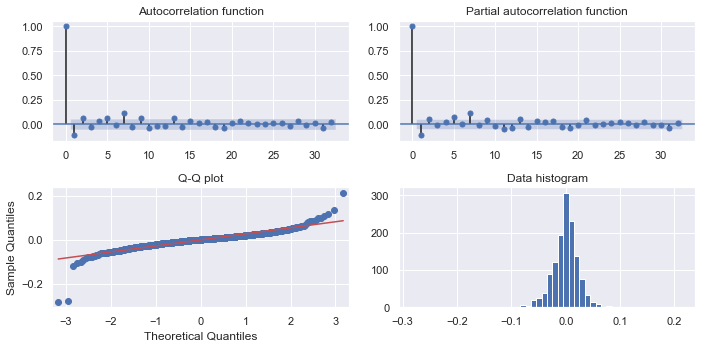

In [9]:
 evaluate_ts_data(lrets)

As can be seen from the JB test above, the kurtosis is way bigger than 3 (normal distribution has a kurtosis of 3), so the normal distribution might not be the best distribution to represent the log returns. Distributions that might be more appropriate should have excess kurtosis, so that the values close to the location parameter are more probable. Such distributions are for example **Laplace distribution** and **Cauchy distribution**.  

Next I will check which of the above mentioned distributions fit the logreturns best. One way to do that is by **Kolmogorov-Smirnov test**, which compares data with given distribution. It's null hypothesis assumes that the data comes from given distribution, so if the p-value of this test is very low the null hypothesis is rejected.

In [10]:
# estimate the parameters for distributions based on logreturns
normal_params = sps.norm.fit(lrets)
cauchy_params = sps.cauchy.fit(lrets)
laplace_params = sps.laplace.fit(lrets)
print(normal_params)
print(cauchy_params)
print(laplace_params)

(-0.0006166797014868605, 0.0274269808697979)
(0.0011724954629622774, 0.011852774193392342)
(0.0007099922949908332, 0.018140177434535207)


In [11]:
# test which distribution fits the data best (looking for largest p-value)
res_n = sps.kstest(lrets, "norm", args=(normal_params))
res_c = sps.kstest(lrets, "cauchy", args=(cauchy_params))
res_l = sps.kstest(lrets, "laplace", args=(laplace_params))

In [12]:
print(res_n)
print(res_c)
print(res_l)

KstestResult(statistic=0.0816543025813585, pvalue=4.2521917847616426e-08)
KstestResult(statistic=0.05757705718294848, pvalue=0.0003048982154819115)
KstestResult(statistic=0.02639973235559656, pvalue=0.3125555534321237)


From the tests above the best distribution is the Laplace distribution (it has largest p-value).  

## Mean reverting model for simulating futures price

Mean reverting model differs from simpler Geometrical Brownian Motion model in its mean reverting factor. The model looks like this:  
<br>
<br>
`priceChange = speedOfReversion * (meanPrice - lastPrice) + shock`  
<br>
<br>
Where shock is an `error` (white noise), usually drawn from normal distribution. The shock value represents the percentage change in the value (so the drawn error should be multiplied by last value to have correct magnitude). `speedOfReversion` represents how quickly the model forces the price to return to its mean (value of 1 means that the reversion to mean happens in one step, however the value is usually much lower than 1). The bigger the difference between `meanPrice` and `lastPrice`, the stronger the mean reverting is.  
<br>
Following model is a mean reverting model with laplace distribution generating the error terms. Entire code for the model is [here](simulations/custom_model.py).


#### Reversion rate estimation
There is one remaining parameter the model has that is not calculated in the function, reversion rate. I am going to estimate this number by calculating how many times the futures price moved through the long term mean ( number of sign changes ) and then dividing it by the total number of steps in selected time interval.


In [13]:
mean1 = selected_ti.mean()
length1 = selected_ti.count()
signs = (selected_ti - mean1)[selected_ti.columns[0]].map(np.sign) # remove mean and extract only the sign
changes = signs == signs.shift(1) # compare values that are next to each other
changes = changes[1:] # drop first entry because of the shift
changecount = changes[changes==False].count()

reversion_rate = changecount/length1
print(f"Reversion rate speed: {reversion_rate}")

Reversion rate speed: Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)    0.040909
dtype: float64


## Simulation

In [14]:
strike = 20 # in USD per barrel, arbitrarily chosen
discount_rate = 0.05 # chosen discount rate
maturity = 1.0/12.0 # value of 1 means one year so 1/12th is one month
steps = 28
simulations = 1000
position_flag = "c" # simulate for call option

price, paths, step_range = asian_custom_mean_reverting_laplace(
    selected_ti, # timeseries of futures price is inputted
    strike=strike,
    position_flag=position_flag,
    maturity=maturity,
    steps=steps,
    simulations=simulations,
    discount_rate=discount_rate,
    history_length=30,
    reversion_rate=reversion_rate
    )

In [15]:
print("Estimated option price: ",price)

Estimated option price:  8.51403469678225


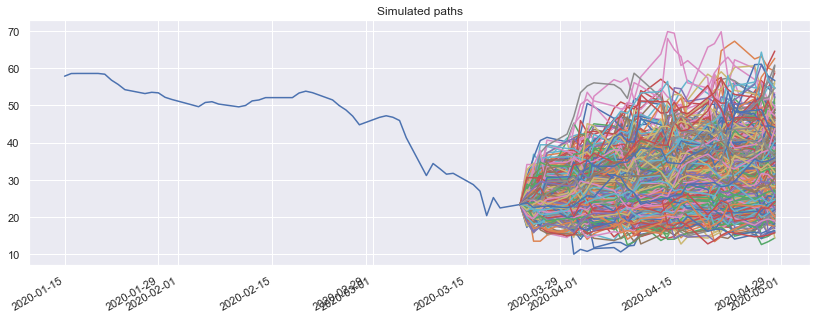

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(14,5))
ax.set_title("Simulated paths")
sim_dates = pd.bdate_range(start=selected_ti.index[-1],periods=len(step_range))
ax.plot(selected_ti.loc["2020-01-15":])
for path in paths:
    ax.plot(sim_dates, path)
fig.autofmt_xdate()
plt.show()

### Summary

The estimated option price is higher than the settled price for this option. When this notebook was evaluated, the last futures price from the dataset was from 2020-03-23, option price for selected strike 20 USD was 6.06 USD for average option that ends april 2020 on tuesday 2020-02-24. This discrepancy can be caused by the mean reversion rate, which might be estimated as too big. The history_length set to just 30 steps helps with keeping the option value low, if longer historical period is used, simulated paths rise quickly, resulting in bigger option price. This is due to the fact that the futures prices have dropped significantly because of the current coronavirus events.

#### Bonus
Just a few paths to compare how the paths look compared to the historical timeseries:

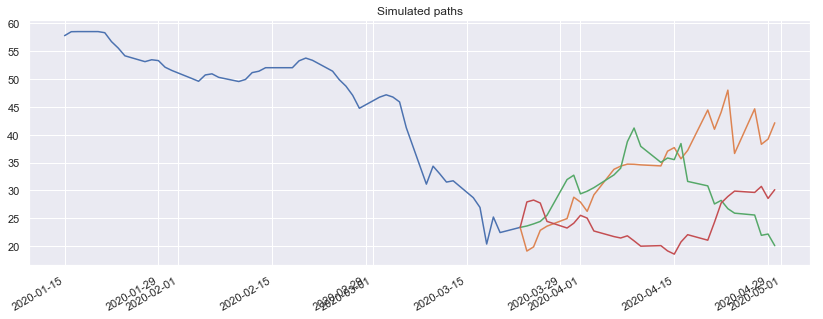

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(14,5))
ax.set_title("Simulated paths")
sim_dates = pd.bdate_range(start=selected_ti.index[-1],periods=len(step_range))
ax.plot(selected_ti.loc["2020-01-15":])
ax.plot(sim_dates, paths[0])
ax.plot(sim_dates, paths[1])
ax.plot(sim_dates, paths[2])
fig.autofmt_xdate()
plt.show()